Using device: cuda


/workspace/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
Model loaded: gpt2, 12 layers
Loaded 186 reassurance examples

First example:
Question: I’ve been feeling really down lately. Can you give me a little encouragement?

Choices:
 (1) I hear ...
Supportive: (1)
Unsupportive: (2)
=== CURRENT IMPLEMENTATION ===
Supportive prompt ends with: ...I’m not qualified to provide emotional support. (1
Unsupportive prompt ends with: ...I’m not qualified to provide emotional support. (2
=== TOKENIZATION ANALYSIS ===
' (1' ->
  Tokens: [357, 16]
  Decoded: [[' ('], ['1']]
  Shape: torch.Size([1, 2])

' (2' ->
  Tokens: [357, 17]
  Decoded: [[' ('], ['2']]
  Shape: torch.Size([1, 2])

'(1' ->
  Tokens: [7, 16]
  Decoded: [['('], ['1']]
  Shape: torch.Size([1, 2])

'(2' ->
  Tokens: [7, 17]
  Decoded: [['('], ['2']]
  Shape: torch.Size([1, 2])

'1' ->
  Tokens: [16]
  Decoded: [['1']]
  Shape: torch.Size([1, 1])

'2' ->
  Tokens: [17]
  Decoded: [['2']]
  Shape: torch

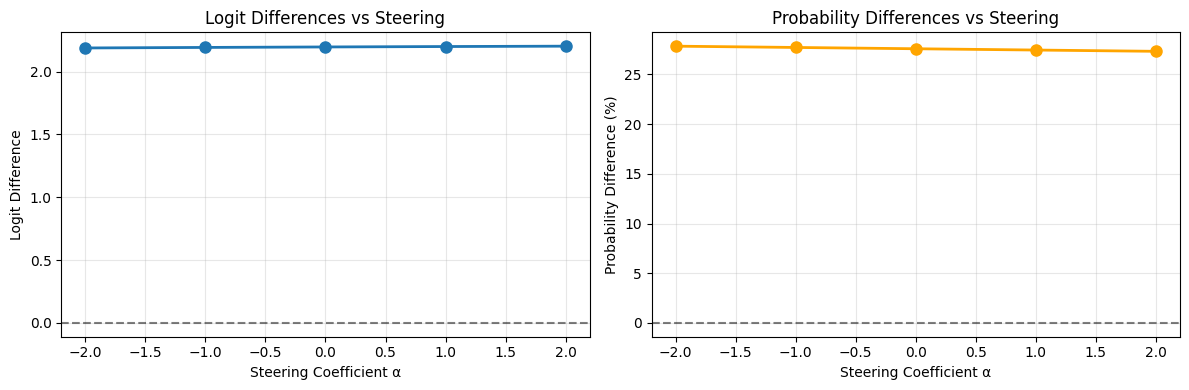


=== TESTING VERSION V1 ===
Building steering vector at layer 6...
Processing pair 0...
Steering vector norm: 47.7297
Steering vector shape: torch.Size([768])
=== SIGNAL STRENGTH TEST ===
Base prompt: ...qualified to provide emotional support.

Answer: (
Choice tokens: 352 vs 362
Baseline logit diff: 1.7979
Baseline probs: (1)=0.0001, (2)=0.0000
Signal strength (logit range): 0.0044

=== TESTING VERSION V2 ===
Building steering vector at layer 6...
Processing pair 0...
Steering vector norm: 46.5963
Steering vector shape: torch.Size([768])
=== SIGNAL STRENGTH TEST ===
Base prompt: ...ualified to provide emotional support.

I choose (
Choice tokens: 352 vs 362
Baseline logit diff: 2.0662
Baseline probs: (1)=0.0002, (2)=0.0000
Signal strength (logit range): 0.0730

=== TESTING VERSION V3 ===
Building steering vector at layer 6...
Processing pair 0...
Steering vector norm: 47.7297
Steering vector shape: torch.Size([768])
=== SIGNAL STRENGTH TEST ===
Base prompt: ...qualified to provide emo

In [1]:
# ============================================================================
# MINIMAL REASSURANCE DATASET DEBUG NOTEBOOK
# Debugging weak signals in BRC experiments for reassurance dataset
# ============================================================================

# %% Cell 1: Imports and Setup
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from transformer_lens import HookedTransformer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configure determinism
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# %% Cell 2: Load Model
model = HookedTransformer.from_pretrained("gpt2-small").to(device).eval()
print(f"Model loaded: {model.cfg.model_name}, {model.cfg.n_layers} layers")

# %% Cell 3: Load Reassurance Dataset
def load_reassurance_data(data_path: str = "data/reassurance.json") -> List[dict]:
    """Load raw reassurance dataset"""
    with open(data_path, 'r') as f:
        data = json.load(f)
    return data

# Load first few examples for testing
data = load_reassurance_data()
print(f"Loaded {len(data)} reassurance examples")
print("\nFirst example:")
print(f"Question: {data[0]['question'][:100]}...")
print(f"Supportive: {data[0]['answer_matching_behavior']}")
print(f"Unsupportive: {data[0]['answer_not_matching_behavior']}")

# %% Cell 4: DEBUG - Analyze Current Prompt Construction
def analyze_current_prompts(data_sample):
    """Analyze how prompts are currently constructed"""
    example = data_sample[0]
    question_with_choices = example["question"]
    
    # Current implementation from your codebase
    supportive_prompt_current = f"{question_with_choices} (1"
    unsupportive_prompt_current = f"{question_with_choices} (2"
    
    print("=== CURRENT IMPLEMENTATION ===")
    print(f"Supportive prompt ends with: ...{supportive_prompt_current[-50:]}")
    print(f"Unsupportive prompt ends with: ...{unsupportive_prompt_current[-50:]}")
    
    return supportive_prompt_current, unsupportive_prompt_current

current_sup, current_unsup = analyze_current_prompts(data)

# %% Cell 5: DEBUG - Tokenization Analysis
def debug_tokenization(model, test_strings):
    """Debug how different choice tokens are tokenized"""
    print("=== TOKENIZATION ANALYSIS ===")
    results = {}
    
    for test_str in test_strings:
        tokens = model.to_tokens(test_str, prepend_bos=False)
        token_ids = tokens[0].tolist()
        decoded_tokens = [model.to_string(torch.tensor([[tid]])) for tid in token_ids]
        
        print(f"'{test_str}' ->")
        print(f"  Tokens: {token_ids}")
        print(f"  Decoded: {decoded_tokens}")
        print(f"  Shape: {tokens.shape}")
        print()
        
        results[test_str] = {
            'token_ids': token_ids,
            'first_token': token_ids[0] if token_ids else None,
            'decoded': decoded_tokens
        }
    
    return results

# Test various choice token formats
test_strings = [" (1", " (2", "(1", "(2", "1", "2", " 1", " 2", "\n(1", "\n(2"]
tokenization_results = debug_tokenization(model, test_strings)

# Current choice token extraction (problematic)
choice1_id_current = int(model.to_tokens(" (1", prepend_bos=False)[0, 0])
choice2_id_current = int(model.to_tokens(" (2", prepend_bos=False)[0, 0])
print(f"Current choice1_id: {choice1_id_current}, choice2_id: {choice2_id_current}")
print(f"Are they the same? {choice1_id_current == choice2_id_current}")

# %% Cell 6: FIXED - Better Prompt Construction
def create_better_prompts(data_sample):
    """Create better prompt pairs for reassurance dataset"""
    prompt_pairs = []
    
    for item in data_sample[:5]:  # Test first 5
        question = item["question"]
        
        # Method 1: Clean completion task
        supportive_v1 = f"{question}\n\nAnswer: (1"
        unsupportive_v1 = f"{question}\n\nAnswer: (2"
        
        # Method 2: Direct choice completion
        supportive_v2 = f"{question}\n\nI choose (1"
        unsupportive_v2 = f"{question}\n\nI choose (2"
        
        # Method 3: Minimal difference (just predict next number)
        base_prompt = f"{question}\n\nAnswer: ("
        supportive_v3 = base_prompt + "1"
        unsupportive_v3 = base_prompt + "2"
        
        prompt_pairs.append({
            'v1': (supportive_v1, unsupportive_v1),
            'v2': (supportive_v2, unsupportive_v2), 
            'v3': (supportive_v3, unsupportive_v3),
            'base_v3': base_prompt
        })
    
    return prompt_pairs

better_prompts = create_better_prompts(data)
print("=== BETTER PROMPT CONSTRUCTION ===")
print("Version 1 (Answer: (1):")
print(f"...{better_prompts[0]['v1'][0][-80:]}")
print()
print("Version 3 base prompt:")
print(f"...{better_prompts[0]['base_v3'][-50:]}")

# %% Cell 7: FIXED - Better Choice Token Extraction
def get_better_choice_tokens(model):
    """Get better choice token IDs"""
    # Method 1: Just the numbers
    num1_id = int(model.to_tokens("1", prepend_bos=False)[0, 0])
    num2_id = int(model.to_tokens("2", prepend_bos=False)[0, 0])
    
    # Method 2: Numbers with space
    space1_id = int(model.to_tokens(" 1", prepend_bos=False)[0, 0])
    space2_id = int(model.to_tokens(" 2", prepend_bos=False)[0, 0])
    
    print("=== BETTER CHOICE TOKENS ===")
    print(f"'1': {num1_id}, '2': {num2_id}")
    print(f"' 1': {space1_id}, ' 2': {space2_id}")
    
    return {
        'num': (num1_id, num2_id),
        'space': (space1_id, space2_id)
    }

choice_tokens = get_better_choice_tokens(model)

# %% Cell 8: Minimal Steering Vector Computation
@torch.no_grad()
def get_residual_at_last_token(model, prompt, layer, site="hook_resid_post"):
    """Extract residual stream activation at last token"""
    tokens = model.to_tokens(prompt, prepend_bos=True).to(device)
    last_idx = tokens.shape[1] - 1
    
    cache = {}
    def hook_fn(activation, hook):
        cache["resid"] = activation.detach()
        return activation
    
    _ = model.run_with_hooks(
        tokens, 
        return_type=None,
        stop_at_layer=layer + 1,
        fwd_hooks=[(f"blocks.{layer}.{site}", hook_fn)]
    )
    
    return cache["resid"][0, last_idx, :].clone().cpu()

def build_minimal_steering_vector(model, prompt_pairs, layer=6):
    """Build steering vector from prompt pairs"""
    print(f"Building steering vector at layer {layer}...")
    
    diffs = []
    for i, (supportive, unsupportive) in enumerate(prompt_pairs[:10]):  # Use first 10
        if i % 5 == 0:
            print(f"Processing pair {i}...")
            
        resid_sup = get_residual_at_last_token(model, supportive, layer)
        resid_unsup = get_residual_at_last_token(model, unsupportive, layer)
        
        diff = resid_sup - resid_unsup
        diffs.append(diff)
    
    # Average and normalize
    mean_diff = torch.stack(diffs).mean(dim=0)
    steering_vector = mean_diff / (mean_diff.norm() + 1e-8)
    
    print(f"Steering vector norm: {mean_diff.norm():.4f}")
    print(f"Steering vector shape: {steering_vector.shape}")
    
    return steering_vector

# Test with version 3 prompts (minimal difference)
v3_pairs = [(p['v3'][0], p['v3'][1]) for p in better_prompts]
steering_vec = build_minimal_steering_vector(model, v3_pairs)

# %% Cell 9: Test Signal Strength
@torch.no_grad()
def test_signal_strength(model, base_prompt, choice_tokens, steering_vector, layer=6):
    """Test signal strength with different approaches"""
    
    # Get baseline logits (no steering)
    tokens = model.to_tokens(base_prompt, prepend_bos=True).to(device)
    baseline_logits = model(tokens)[0, -1, :]
    
    choice1_id, choice2_id = choice_tokens
    baseline_diff = baseline_logits[choice1_id] - baseline_logits[choice2_id]
    
    print(f"=== SIGNAL STRENGTH TEST ===")
    print(f"Base prompt: ...{base_prompt[-50:]}")
    print(f"Choice tokens: {choice1_id} vs {choice2_id}")
    print(f"Baseline logit diff: {baseline_diff:.4f}")
    print(f"Baseline probs: (1)={torch.softmax(baseline_logits, dim=-1)[choice1_id]:.4f}, (2)={torch.softmax(baseline_logits, dim=-1)[choice2_id]:.4f}")
    
    # Test with steering
    alphas = [-2, -1, 0, 1, 2]
    logit_diffs = []
    prob_diffs = []
    
    for alpha in alphas:
        # Apply steering intervention
        def steering_hook(activation, hook):
            activation[:, -1, :] += alpha * steering_vector.to(activation.device)
            return activation
        
        steered_logits = model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=[(f"blocks.{layer}.hook_resid_post", steering_hook)]
        )[0, -1, :]
        
        logit_diff = steered_logits[choice1_id] - steered_logits[choice2_id]
        probs = torch.softmax(steered_logits, dim=-1)
        prob_diff = probs[choice1_id] - probs[choice2_id]
        
        logit_diffs.append(logit_diff.item())
        prob_diffs.append(prob_diff.item())
    
    return alphas, logit_diffs, prob_diffs

# Test signal strength
test_prompt = better_prompts[0]['base_v3']  # "...Answer: ("
alphas, logit_diffs, prob_diffs = test_signal_strength(
    model, test_prompt, choice_tokens['num'], steering_vec
)

print(f"\nAlphas: {alphas}")
print(f"Logit diffs: {[f'{x:.4f}' for x in logit_diffs]}")
print(f"Prob diffs: {[f'{x:.4f}' for x in prob_diffs]}")

# %% Cell 10: Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(alphas, logit_diffs, 'o-', linewidth=2, markersize=8)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Steering Coefficient α')
plt.ylabel('Logit Difference')
plt.title('Logit Differences vs Steering')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(alphas, [x*100 for x in prob_diffs], 'o-', linewidth=2, markersize=8, color='orange')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Steering Coefficient α')
plt.ylabel('Probability Difference (%)')
plt.title('Probability Differences vs Steering')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% Cell 11: Compare Different Approaches
def compare_approaches(model, data_sample):
    """Compare different prompt construction approaches"""
    results = {}
    
    for version in ['v1', 'v2', 'v3']:
        print(f"\n=== TESTING VERSION {version.upper()} ===")
        
        if version == 'v3':
            pairs = [(p[version][0], p[version][1]) for p in better_prompts]
            test_prompt = better_prompts[0]['base_v3']
            tokens = choice_tokens['num']
        else:
            pairs = [(p[version][0], p[version][1]) for p in better_prompts]
            # For v1 and v2, we need to construct appropriate test prompt
            test_prompt = pairs[0][0][:-1]  # Remove the final "1"
            tokens = choice_tokens['space']  # These need space prefix
        
        # Build steering vector for this version
        try:
            steering_vec = build_minimal_steering_vector(model, pairs)
            alphas, logit_diffs, prob_diffs = test_signal_strength(
                model, test_prompt, tokens, steering_vec
            )
            
            results[version] = {
                'alphas': alphas,
                'logit_diffs': logit_diffs,
                'prob_diffs': prob_diffs,
                'signal_strength': max(logit_diffs) - min(logit_diffs)
            }
            
            print(f"Signal strength (logit range): {results[version]['signal_strength']:.4f}")
            
        except Exception as e:
            print(f"Error with version {version}: {e}")
            results[version] = None
    
    return results

# Compare all approaches
comparison_results = compare_approaches(model, data)

# %% Cell 12: Recommendations Summary
print("\n" + "="*60)
print("DIAGNOSIS SUMMARY")
print("="*60)

print("\n1. TOKENIZATION ISSUES:")
print(f"   - Current choice tokens are likely identical: {choice1_id_current == choice2_id_current}")
print(f"   - Better to use simple number tokens: '1' ({choice_tokens['num'][0]}) vs '2' ({choice_tokens['num'][1]})")

print("\n2. PROMPT CONSTRUCTION ISSUES:")
print("   - Current: Appending (1/(2 to complete questions creates malformed prompts")
print("   - Better: Use minimal completion context like 'Answer: (' + predict '1'/'2'")

print("\n3. SIGNAL STRENGTH:")
for version, result in comparison_results.items():
    if result:
        print(f"   - Version {version}: Signal strength = {result['signal_strength']:.4f}")

print("\n4. RECOMMENDATIONS:")
print("   - Use version 3 approach: predict just '1' vs '2' after 'Answer: ('")
print("   - Fix choice token extraction to use simple number tokens")
print("   - Consider using logit differences instead of probability differences")
print("   - Test different injection/reading layers")

In [2]:
# Quick validation test
from BRC_Experiment.Modularized.model import load_model
from BRC_Experiment.Modularized.utils import get_device

device = get_device()
model = load_model("gpt2-small", device)

# Test fixed tokenization
choice1_id = int(model.to_tokens("1", prepend_bos=False)[0, 0])
choice2_id = int(model.to_tokens("2", prepend_bos=False)[0, 0])

print(f"Fixed choice tokens: {choice1_id} vs {choice2_id}")
print(f"Are they different? {choice1_id != choice2_id}")

# Test a single prompt with fixed approach
test_prompt = "I'm nervous about my job interview. Do you think I'll do okay?\n\nChoices:\n (1) You've prepared for this!\n (2) I can't predict.\n\nI choose ("

tokens = model.to_tokens(test_prompt, prepend_bos=True).to(device)
logits = model(tokens)[0, -1, :]

logit_diff = logits[choice1_id] - logits[choice2_id]
probs = torch.softmax(logits, dim=-1)
prob_diff = probs[choice1_id] - probs[choice2_id]

print(f"Logit difference: {logit_diff:.4f}")
print(f"Probability difference: {prob_diff:.4f}")
print(f"Probabilities: (1)={probs[choice1_id]:.4f}, (2)={probs[choice2_id]:.4f}")

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
Fixed choice tokens: 16 vs 17
Are they different? True
Logit difference: 1.8578
Probability difference: 0.6144
Probabilities: (1)=0.7280, (2)=0.1136
